In [1]:
from xgboost import XGBRegressor

In [2]:
from z3 import *
import numpy as np


class XGBoostExplainer:
    def __init__(self, model, data):
        self.model = model
        self.data = data.values
        self.columns = data.columns
        self.max_categories = 2

        set_option(rational_to_decimal=True)
        self.categoric_features = self.get_categoric_features(self.data)
        self.T_model = self.model_trees_expression(self.model)
        self.T = self.T_model

    def explain(self, instance, reorder="asc"):
        self.I = self.instance_expression(instance)
        self.D, self.D_add = self.decision_function_expression(self.model, [instance])
        return self.explain_expression(self.I, And(self.T, self.D_add), self.D, self.model, reorder)

    def explain_prob(self, instance, reorder="asc", threshold_margin=0, target_threshold=None):
        self.I = self.instance_expression(instance)
        self.D, self.D_add = self.decision_function_expression(self.model, [instance])
        return self.explain_expression_prob(self.I, And(self.T, self.D_add), self.D, self.model, reorder, threshold_margin, target_threshold)

    def get_categoric_features(self, data: np.ndarray):
        categoric_features = []
        for i in range(data.shape[1]):
            feature_values = data[:, i]
            unique_values = np.unique(feature_values)
            if len(unique_values) <= self.max_categories:
                categoric_features.append(self.columns[i])

        return categoric_features

    def feature_constraints(self, constraints=[]):
        """TODO
        esperado receber limites das features pelo usuário
        formato previso: matriz/dataframe [feaature, min/max, valor]
        constraaint_expression = "constraaint_df_to_feature()"
        """
        return

    def model_trees_expression(self, model):
        df = model.get_booster().trees_to_dataframe()
        if model.get_booster().feature_names == None:
            feature_map = {f"f{i}": col for i, col in enumerate(self.columns)}
            df["Feature"] = df["Feature"].replace(feature_map)

        df["Split"] = df["Split"].round(4)
        self.booster_df = df
        class_index = 0  # if model.n_classes_ == 2:
        all_tree_formulas = []

        for tree_index in df["Tree"].unique():
            tree_df = df[df["Tree"] == tree_index]
            o = Real(f"o_{tree_index}_{class_index}")

            if len(tree_df) == 1 and tree_df.iloc[0]["Feature"] == "Leaf":
                leaf_value = tree_df.iloc[0]["Gain"]
                all_tree_formulas.append(And(o == leaf_value))
                continue
            path_formulas = []

            def get_conditions(node_id):
                conditions = []
                current_node = tree_df[tree_df["ID"] == node_id]
                if current_node.empty:
                    return conditions

                parent_node = tree_df[
                    (tree_df["Yes"] == node_id) | (tree_df["No"] == node_id)
                ]
                if not parent_node.empty:
                    parent_data = parent_node.iloc[0]
                    feature = parent_data["Feature"]
                    split_value = parent_data["Split"]
                    x = Real(feature)
                    if parent_data["Yes"] == node_id:
                        conditions.append(x < split_value)
                    else:
                        conditions.append(x >= split_value)
                    conditions = get_conditions(parent_data["ID"]) + conditions

                return conditions

            for _, node in tree_df[tree_df["Feature"] == "Leaf"].iterrows():
                leaf_value = node["Gain"]
                leaf_id = node["ID"]
                conditions = get_conditions(leaf_id)
                path_formula = And(*conditions)
                implication = Implies(path_formula, o == leaf_value)
                path_formulas.append(implication)

            all_tree_formulas.append(And(*path_formulas))
        return And(*all_tree_formulas)

    def get_init_value(self, model, x, estimator_variables):
        estimator_pred = Solver()
        estimator_pred.add(self.I)
        estimator_pred.add(self.T)
        if estimator_pred.check() == sat:
            solvermodel = estimator_pred.model()
            total_sum = sum(
                float(solvermodel.eval(var).as_fraction()) for var in estimator_variables
            )
        else:
            total_sum = 0
            print("estimator error")
        self.predicted_margin = model.predict(x, output_margin=True)[0]
        init_value = self.predicted_margin - total_sum
        self.init_value = init_value
        return init_value

    def decision_function_expression(self, model, x):
        n_classes = 1 if model.n_classes_ <= 2 else model.n_classes_
        predicted_class = model.predict(x)[0]
        self.predicted_class = predicted_class
        n_estimators = int(len(model.get_booster().get_dump()) / n_classes)
        estimator_variables = [Real(f"o_{i}_0") for i in range(n_estimators)] # _0 only for binary classification
        self.estimator_variables = estimator_variables
        init_value = self.get_init_value(model, x, estimator_variables)
        # print("init:", round(init_value, 2))

        equation_list = []

        estimator_sum = Real("estimator_sum")
        equation_o = estimator_sum == Sum(estimator_variables)
        equation_list.append(equation_o)

        decision = Real("decision")
        equation_list.append(decision == estimator_sum + init_value)

        if predicted_class == 0:
            final_equation = decision < 0
        else:
            final_equation = decision > 0

        return final_equation, And(equation_list)

    def instance_expression(self, instance):
        formula = [Real(self.columns[i]) == value for i, value in enumerate(instance)]
        return formula

    def explain_expression(self, I, T_s, D_s, model, reorder):
        i_expression = I.copy()

        importances = model.feature_importances_
        non_zero_indices = np.where(importances != 0)[0]

        if reorder == "asc":
            sorted_feature_indices = non_zero_indices[
                np.argsort(importances[non_zero_indices])
            ]
            i_expression = [i_expression[i] for i in sorted_feature_indices]
        elif reorder == "desc":
            sorted_feature_indices = non_zero_indices[
                np.argsort(-importances[non_zero_indices])
            ]
            i_expression = [i_expression[i] for i in sorted_feature_indices]

        for feature in i_expression.copy():
            # print("\n---removed", feature)
            i_expression.remove(feature)

            # prove(Implies(And(And(i_expression), T), D))
            if self.is_proved(Implies(And(And(i_expression), T_s), D_s)):
                continue
                # print('proved')
            else:
                # print('not proved')
                i_expression.append(feature)
        # print(self.is_proved(Implies(And(And(i_expression), T_s), D_s)))
        return i_expression

    def explain_expression_prob(self, I, T_s, D_s, model, reorder, threshold_margin, target_threshold):
        i_expression = I.copy()

        importances = model.feature_importances_
        non_zero_indices = np.where(importances != 0)[0]

        if reorder == "asc":
            sorted_feature_indices = non_zero_indices[
                np.argsort(importances[non_zero_indices])
            ]
            i_expression = [i_expression[i] for i in sorted_feature_indices]
        elif reorder == "desc":
            sorted_feature_indices = non_zero_indices[
                np.argsort(-importances[non_zero_indices])
            ]
            i_expression = [i_expression[i] for i in sorted_feature_indices]

        threshold = 0

        if target_threshold:
            threshold = target_threshold
        elif threshold_margin != 0:
            threshold = self.predicted_margin * threshold_margin/100
            # print("margin:", self.predicted_margin, "accepted margin:", threshold)
        self.xai_predicted_margin = self.predicted_margin

        for feature in i_expression.copy():
            # print("\n---removed", feature)
            i_expression.remove(feature)

            if self.is_proved_sat(And(And(i_expression), T_s), threshold):
                # print('proved')
                continue
            else:
                # print('not proved -- added back')
                i_expression.append(feature)
        return i_expression


    def is_proved(self, decision_exp):
        s = Solver()
        s.add(Not(decision_exp))
        if s.check() == unsat:
            return True
        else:
            # print(s.model())
            return False

    def is_proved_sat(self, decision_exp, threshold):
      decision = Real("decision")

      debug = Real("debug") == 0
      predicted_class = self.predicted_class

      if predicted_class == 0:
        estmax = Optimize()
        estmax.add(decision_exp)
        estmax.add(debug)
        maxvalue = estmax.maximize(decision)
        if estmax.check() == sat:
            # print("\nmax sat", maxvalue.value())
            try:
              if float(maxvalue.value().as_fraction()) > threshold:
                  return False # can change class
              else:
                  self.xai_predicted_margin = float(maxvalue.value().as_fraction())
            except:
              print("error max =", maxvalue.value())
              return False
        else:
            print("error")

      if predicted_class == 1:
        estmin = Optimize()
        estmin.add(decision_exp)
        estmin.add(debug)
        minvalue = estmin.minimize(decision)
        if estmin.check() == sat:
            # print("\nmin sat", minvalue.value())
            try:
              if float(minvalue.value().as_fraction()) < threshold:
                  return False # can change class
              else:
                  self.xai_predicted_margin = float(minvalue.value().as_fraction())
            except:
              print("error min =", minvalue.value())
              return False
        else:
            print("error")

      if predicted_class == 0:
        self.solvermodel = estmax.model()
      if predicted_class == 1:
        self.solvermodel = estmin.model()
      return True

# simple model

In [3]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor, plot_tree
import matplotlib.pyplot as plt


In [4]:
# Dataset simples e pequeno
X = pd.DataFrame({
    "x1": [1, 2, 3, 4, 5, 6],
    "x2": [10, 20, 30, 40, 50, 60],
})

y = np.array([3, 6, 9, 12, 15, 18])


In [5]:
n_estimators = 2

model = XGBRegressor(
    n_estimators=n_estimators,      # poucas árvores
    max_depth=2,         # árvores pequenas
    learning_rate=1.0,   # sem shrinkage para facilitar interpretação
    random_state=42,
)

model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1.0, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

<Figure size 1200x600 with 0 Axes>

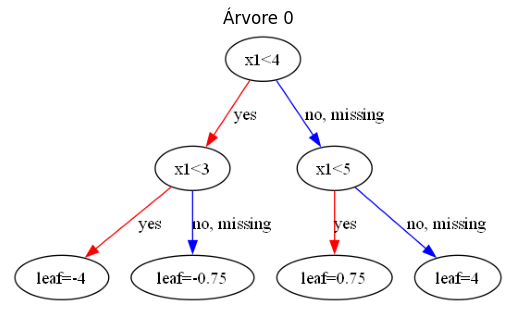

<Figure size 1200x600 with 0 Axes>

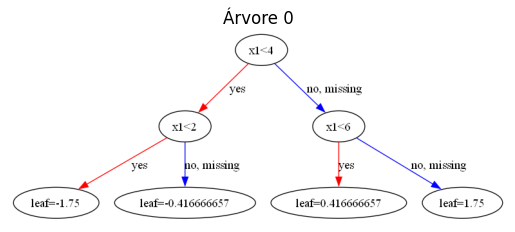

In [6]:
for i in range(n_estimators):
    plt.figure(figsize=(12, 6))
    plot_tree(model, num_trees=i)
    plt.title("Árvore 0")
    plt.show()


In [7]:
booster = model.get_booster()

booster.get_dump(with_stats=True)


['0:[x1<4] yes=1,no=2,missing=2,gain=91.125,cover=6\n\t1:[x1<3] yes=3,no=4,missing=4,gain=3.5625,cover=3\n\t\t3:leaf=-4,cover=2\n\t\t4:leaf=-0.75,cover=1\n\t2:[x1<5] yes=5,no=6,missing=6,gain=3.5625,cover=3\n\t\t5:leaf=0.75,cover=1\n\t\t6:leaf=4,cover=2\n',
 '0:[x1<4] yes=1,no=2,missing=2,gain=11.28125,cover=6\n\t1:[x1<2] yes=3,no=4,missing=4,gain=1.00520849,cover=3\n\t\t3:leaf=-1.75,cover=1\n\t\t4:leaf=-0.416666657,cover=2\n\t2:[x1<6] yes=5,no=6,missing=6,gain=1.00520849,cover=3\n\t\t5:leaf=0.416666657,cover=2\n\t\t6:leaf=1.75,cover=1\n']